In [2]:
import torch 
from torch import nn 

import math 
import matplotlib.pyplot as plt 
import torchvision 
import torchvision.transforms as transforms
from torch.optim import Adam

##### * GAN learns the distribution of data and will also generate digits with different handwriting styles *

## DISCRIMINATOR 

MLP Neural Network that receives an image and provides the probability of the image belonging to the real training data. 

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(), 
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            )
        
    def forward(self, x):
        # converts the shape of the input tensor - 
        # converts from 32x1x28x28 to 32x784 
        # to input image coefficients into MLP, vectorize them so nn receives vectors with 784 coefficients 
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output 
    
discriminator = Discriminator()

## GENERATOR

generates complex data, therefore necessary to increase dimensions of input from the latent space. 

the generator ill be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organised in a 28x28 tensor representing an image. 

Using hyperbolic tangent function Tanh() as the activation of the output layer since the output cocefficients [-1,1] 

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,784),
            nn.Tanh(),
            )
        
    def forward(self,x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output
    
generator = Generator()

In [5]:
# Models defined. 
# Training the models using the training data
n = 0.0001
epochs = 50

loss_func = nn.BCELoss()

optimizer_discriminator = Adam(discriminator.parameters(), lr=n)
optimizer_generator = Adam(generator.parameters(), lr=n)

*for obtaining better result, decrease the learning rate*

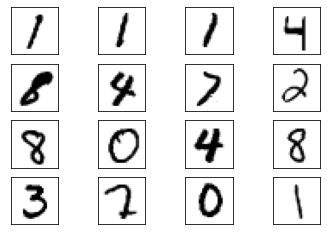

In [6]:
# setting up random generator seed 
torch.manual_seed(111)

# for using the dataset with pytorch, we need to perform some conversations using transform
# ToTensor() - converts data to a pytorch tensor [range = 0 to 1]
# Normalize() - converts the range of the tensor coefficients [range = -1 to 1]
# with this transformation, the no of elements equal to 0 in the input samples is reduced, which is better for training models.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# loading dataset and performing transform conversion 
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle= True)

# plotting the samples of the training data 
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(real_samples[i].reshape(28,28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [7]:
for epoch in range(epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # data for training the discriminator 
        real_samples_labels = torch.ones((batch_size,1))
        latent_space_samples = torch.randn((batch_size,100))
        
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size,1))
        
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # TRAINING THE DISCRIMINATOR
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_func(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # DATA FOR TRAINING THE GENERATOR 
        latent_space_samples = torch.randn((batch_size, 100))
        
        # TRAINING THE GENERATOR 
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_func(output_discriminator_generated, real_samples_labels)
        
        loss_generator.backward()
        optimizer_generator.step()
        
        # loss
        if n == batch_size - 1:
            print(f"epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"epoch: {epoch} Loss G.: {loss_generator}")
        

epoch: 0 Loss D.: 0.5402515530586243
epoch: 0 Loss G.: 0.5068141222000122
epoch: 1 Loss D.: 0.01653718203306198
epoch: 1 Loss G.: 5.1488542556762695
epoch: 2 Loss D.: 0.004604887217283249
epoch: 2 Loss G.: 6.4196248054504395
epoch: 3 Loss D.: 0.10897964984178543
epoch: 3 Loss G.: 5.62264347076416
epoch: 4 Loss D.: 0.06526324152946472
epoch: 4 Loss G.: 3.732619047164917
epoch: 5 Loss D.: 0.04740907624363899
epoch: 5 Loss G.: 4.500436782836914
epoch: 6 Loss D.: 0.06322429329156876
epoch: 6 Loss G.: 4.3583984375
epoch: 7 Loss D.: 0.13264618813991547
epoch: 7 Loss G.: 2.4928407669067383
epoch: 8 Loss D.: 0.14965486526489258
epoch: 8 Loss G.: 4.175390720367432
epoch: 9 Loss D.: 0.08882835507392883
epoch: 9 Loss G.: 3.5546517372131348
epoch: 10 Loss D.: 0.003827220294624567
epoch: 10 Loss G.: 7.186423301696777
epoch: 11 Loss D.: 0.03562784194946289
epoch: 11 Loss G.: 3.452606201171875
epoch: 12 Loss D.: 0.18158404529094696
epoch: 12 Loss G.: 2.5521702766418457
epoch: 13 Loss D.: 0.1918996125

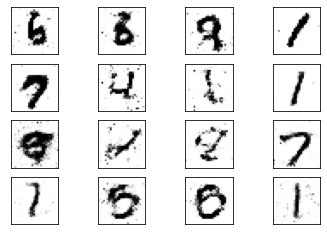

In [8]:
# Checking the samples generated by GAN 

# to generate handwritten digits, taking some random samples 
# from the latent space and feeding them to the generator.
latent_space_samples = torch.randn(batch_size,100)
generated_samples = generator(latent_space_samples)

# plotting the generated samples
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(generated_samples[i].reshape(28,28).detach().numpy(), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

After training for around 50 epochs, the generated digits resemble the real ones. 

The results can be improved by considering more training epochs.

*As the training progresses, the generator learns the distribution of real data, and they start resembling the real data.* 

In [9]:
# End of GAN Implementation 